## [DL 팀프로젝트]
- 대주제 : 반려
- 소주제 : 도지코인
- 데이터셋 :
- 데이터수 : 2164개
- 피쳐갯수 : 5개 (날짜, 시가, 고가, 저가, 거래량)
- 타겟갯수 : 1개 (종가)

[1] 모듈 로딩 및 데이터 준비 <hr>

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [278]:
data = './DOGE-USD.csv'

In [279]:
DOGEDF = pd.read_csv(data)

[2] 데이터 전처리 <hr>

In [280]:
DOGEDF

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270
...,...,...,...,...,...,...,...
2159,2023-10-08,0.061456,0.061611,0.060876,0.061008,0.061008,92483679
2160,2023-10-09,0.061010,0.061030,0.058260,0.058779,0.058779,241183528
2161,2023-10-10,0.058779,0.059204,0.058608,0.059025,0.059025,123311323
2162,2023-10-11,0.059041,0.059454,0.057813,0.058470,0.058470,146066511


In [281]:
# 해당 DF에서 Adj Close(조정 종가)는 코인마켓에서 사용되지 않는 개념이므로 삭제.
DOGEDF = DOGEDF.drop(axis=1, columns = 'Adj Close')

In [282]:
# DOGEDF의 컬럼별 데이터타입 확인
for col in DOGEDF.columns:
    print(f'{col} dtype : {DOGEDF[col].dtype}')

Date dtype : object
Open dtype : float64
High dtype : float64
Low dtype : float64
Close dtype : float64
Volume dtype : int64


In [283]:
# 결측치 체크
DOGEDF.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [284]:
# 결측치 없음을 확인

In [285]:
# Date 컬럼이 현재 object로 되어 있어 Datetime으로 형변환
DOGEDF['Date'] = pd.to_datetime(DOGEDF['Date'])
DOGEDF['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2164 entries, 0 to 2163
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
2164 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.0 KB


In [286]:
DOGEDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2164 non-null   datetime64[ns]
 1   Open    2164 non-null   float64       
 2   High    2164 non-null   float64       
 3   Low     2164 non-null   float64       
 4   Close   2164 non-null   float64       
 5   Volume  2164 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 101.6 KB


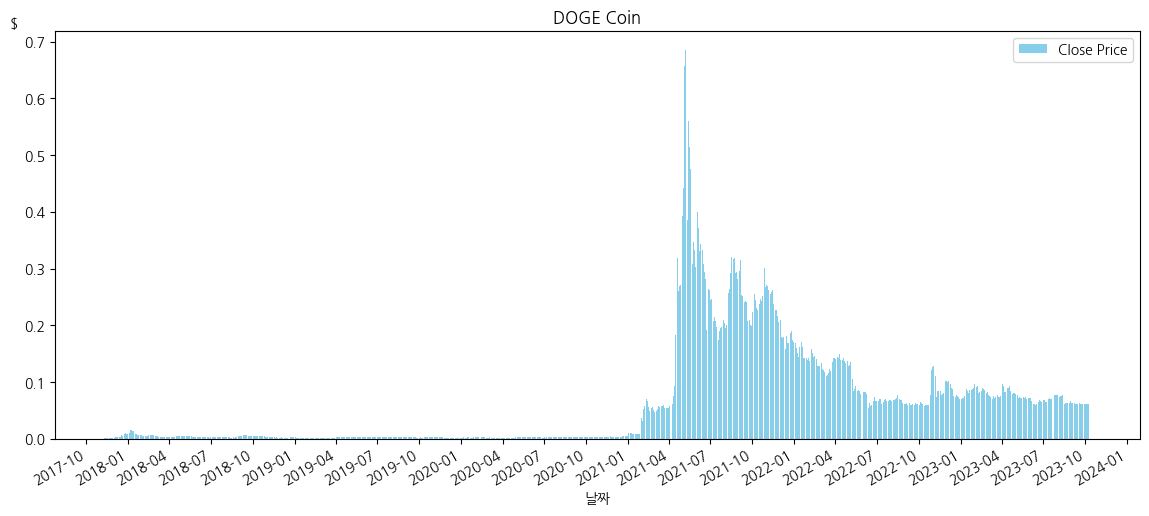

In [287]:
import matplotlib.dates as mdates
import koreanize_matplotlib

plt.figure(figsize=(14,6))
plt.title('DOGE Coin')
plt.bar(DOGEDF.Date, DOGEDF.Close, label='Close Price', color='skyblue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # '년-월' 형식으로 날짜 포맷 설정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.gcf().autofmt_xdate()
plt.xlabel('날짜')
plt.ylabel('$', rotation=360, loc='top')
plt.legend()
plt.show()

In [288]:
# 데이터프레임을 피쳐와 타겟으로 분리 (이거 아님 이러면 망함)
'''
targetSR = DOGEDF['Close']
featureDF = DOGEDF.drop(axis=1, columns='Close')
print(featureDF, targetSR)
'''

"\ntargetSR = DOGEDF['Close']\nfeatureDF = DOGEDF.drop(axis=1, columns='Close')\nprint(featureDF, targetSR)\n"

In [289]:
# 정규화 수행 - 대상 : featureDF에서 시계열 데이터인 Date컬럼을 제외한 나머지
from sklearn.preprocessing import MinMaxScaler

# 1. 날짜 데이터 처리: Date 컬럼을 인덱스로 설정 (시계열 데이터의 순서 유지)
dogeDF = DOGEDF.set_index('Date')

# MinMaxScaler 객체 생성 
scaler = MinMaxScaler()

# 2. Close 컬럼을 제외한 나머지 컬럼 선택 및 정규화
features_columns = dogeDF.drop(['Close'], axis=1).columns
dogeDF[features_columns] = scaler.fit_transform(dogeDF[features_columns])

In [290]:
# 3. 시퀀스 데이터 준비 함수
def create_sequences(features, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(features) - sequence_length):
        seq = features.iloc[i:(i+sequence_length)].values
        label = target.iloc[i+sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# 시퀀스 길이 정의
sequence_length = 30

# 피쳐 및 타겟 데이터 준비
featureDF = dogeDF.drop(['Close'], axis=1)
targetSR = dogeDF['Close']

# 시퀀스 데이터와 타겟 데이터 준비
X, y = create_sequences(featureDF, targetSR, sequence_length)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (2134, 30, 4)
y shape: (2134,)


In [291]:
# 시퀀스 데이터와 타겟 데이터를 NumPy 배열에서 Tensor로 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print(f"X_tensor: {X_tensor.shape}, y_tensor: {y_tensor.shape}")

X_tensor: torch.Size([2134, 30, 4]), y_tensor: torch.Size([2134])


[3] 학습 데이터셋 준비 <hr>

In [292]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# 사용자 정의 데이터셋 인스턴스 생성
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

[4] 데이터 로더 생성 <hr>

In [307]:
batch = 30
train_loader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False)

[5] 모델 준비 <hr>

In [321]:
class TimeSeriesRegressor(nn.Module):
    def __init__(self, input_dim):
        super(TimeSeriesRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [309]:
# 시퀀스 길이는 30, 특성 수는 featureDF의 컬럼 수와 동일
input_dim = sequence_length * len(featureDF.columns)

model = TimeSeriesRegressor(input_dim=input_dim)


In [310]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


[6] 함수 정의 <hr>

In [311]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs=100):
    for epoch in range(epochs):
        model.train()  # 모델을 학습 모드로 설정
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)  # 입력 데이터 평탄화
            optimizer.zero_grad()  # 최적화기의 그래디언트 초기화
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch.unsqueeze(1))  # 손실 계산, 타겟 차원 조정
            loss.backward()  # 손실에 대한 모델 파라미터의 그래디언트 계산
            optimizer.step()  # 파라미터 업데이트
            train_loss += loss.item()

        train_loss /= len(train_loader)
        
        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0
        with torch.no_grad():  # 그래디언트 계산을 비활성화
            for X_val, y_val in val_loader:
                X_val = X_val.view(X_val.size(0), -1)  # 입력 데이터 평탄화
                predictions = model(X_val)
                loss = loss_fn(predictions, y_val.unsqueeze(1))  # 손실 계산, 타겟 차원 조정
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        
        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


[7] 모델 학습 <hr>

In [312]:
train(model, train_loader, val_loader, optimizer, loss_fn, epochs=100)

Epoch 0: Train Loss: 0.0019, Validation Loss: 0.0013
Epoch 1: Train Loss: 0.0006, Validation Loss: 0.0009
Epoch 2: Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 3: Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 4: Train Loss: 0.0002, Validation Loss: 0.0006
Epoch 5: Train Loss: 0.0002, Validation Loss: 0.0003
Epoch 6: Train Loss: 0.0002, Validation Loss: 0.0004
Epoch 7: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 8: Train Loss: 0.0002, Validation Loss: 0.0005
Epoch 9: Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 10: Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 11: Train Loss: 0.0001, Validation Loss: 0.0005
Epoch 12: Train Loss: 0.0001, Validation Loss: 0.0003
Epoch 13: Train Loss: 0.0001, Validation Loss: 0.0004
Epoch 14: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 15: Train Loss: 0.0001, Validation Loss: 0.0002
Epoch 16: Train Loss: 0.0001, Validation Loss: 0.0005
Epoch 17: Train Loss: 0.0001, Validation Loss: 0.0011
Epoch 18: Train Loss: 0.0001, Validati

In [330]:
from sklearn.metrics import r2_score

def evaluate(model, test_loader, loss_fn):
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0
    mse_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for X_test, y_test in test_loader:
            X_test = X_test.view(X_test.size(0), -1)  # 입력 데이터 평탄화
            predictions = model(X_test)
            loss = loss_fn(predictions, y_test.unsqueeze(1))  # 손실 계산, 타겟 차원 조정
            test_loss += loss.item()

            # MSE 계산을 위한 데이터 축적
            mse_loss += ((predictions - y_test.unsqueeze(1)) ** 2).sum().item()
            
            # 결정 계수 계산을 위해 예측값과 실제값 저장
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_targets.extend(y_test.view(-1).cpu().numpy())

    test_loss /= len(test_loader)
    mse_loss /= len(all_targets)  # 전체 샘플 수로 나누어 평균을 계산
    
    # 결정 계수(R² score) 계산
    r2 = r2_score(all_targets, all_predictions)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'평균제곱오차 : {mse_loss:.4f}')
    print(f'결정계수 score: {r2:.4f}')


In [331]:
evaluate(model, test_loader, loss_fn)

Test Loss: 0.0000
평균제곱오차 : 0.0000
결정계수 score: 0.2468


In [315]:
# 모델 저장
torch.save(model.state_dict(), 'model.pth')

In [316]:
model = TimeSeriesRegressor(input_dim=input_dim)
model.load_state_dict(torch.load('model.pth'))
model.eval()  # 모델을 평가 모드로 설정


TimeSeriesRegressor(
  (fc1): Linear(in_features=120, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [317]:
# 평가
import torch.nn.functional as F

def evaluate_model(model, data_loader):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0.0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.view(X_batch.size(0), -1)
            predictions = model(X_batch)
            loss = F.mse_loss(predictions, y_batch.unsqueeze(1))
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

# 검증 데이터셋과 테스트 데이터셋에 대한 성능 평가
val_loss = evaluate_model(model, val_loader)
test_loss = evaluate_model(model, test_loader)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')


Validation Loss: 0.0003
Test Loss: 0.0000


In [318]:
# 테스트 데이터셋에 대한 예측 수행
# 여기서는 예시로 테스트 로더(test_loader)를 사용합니다.
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.view(X_batch.size(0), -1)  # 입력 데이터 평탄화
        prediction = model(X_batch)
        predictions.extend(prediction.numpy().flatten())

# 예시: 첫 5개의 예측값 출력
print("첫 5개의 예측값:", predictions[:5])

첫 5개의 예측값: [0.06554396, 0.06617601, 0.06882472, 0.071786895, 0.07115662]


In [341]:
# 올바르게 작동했는지 체크해보자
predict_date = pd.to_datetime('2023-02-01')
start_date = predict_date - pd.Timedelta(days=sequence_length)
end_date = predict_date - pd.Timedelta(days=1)

# 'Date' 컬럼을 인덱스로 사용하여 해당 기간 동안의 데이터를 추출
input_data = dogeDF.loc[start_date:end_date]

# 필요한 전처리 수행
# 이미 MinMaxScaler로 정규화된 features_columns 사용
input_features = input_data[features_columns].values

# 모델 입력을 위한 차원 조정 및 텐서 변환
input_features = np.expand_dims(input_features, axis=0)  # 배치 차원 추가
input_tensor = torch.tensor(input_features, dtype=torch.float32)

# 모델을 평가 모드로 설정하고 예측 수행
model.eval()
with torch.no_grad():
    input_tensor = input_tensor.reshape(input_tensor.size(0), -1)  # 입력 데이터 평탄화
    prediction = model(input_tensor)

# 예측된 가격
predicted_price = prediction.item()

# 실제 가격
real_price_row = DOGEDF[DOGEDF['Date'] == predict_date.strftime('%Y-%m-%d')]
if not real_price_row.empty:
    real_price = real_price_row['Close'].values[0]
    # 오차율 계산
    error_rate = abs(real_price - predicted_price) / real_price * 100
    print(f"예상 가격 {predict_date.date()} : {predicted_price}")
    print(f"실제 가격 {predict_date.date()} : {real_price}")
    print(f"오차율 : {error_rate:.2f}%")
else:
    print(f"예상 가격 {predict_date.date()}: {predicted_price}")
    print("해당 날짜 실제 가격 데이터 없음", predict_date.date())


예상 가격 2023-02-01 : 0.10420792549848557
실제 가격 2023-02-01 : 0.094171
오차율 : 10.66%


In [320]:
# 오차율을 저장할 리스트 초기화
error_rates = []

# 가능한 모든 예측 시작 날짜 추출 (최소 sequence_length 만큼의 데이터가 필요)
start_dates = dogeDF.index[:-sequence_length]

for start_date in start_dates:
    predict_date = start_date + pd.Timedelta(days=sequence_length)
    end_date = predict_date - pd.Timedelta(days=1)

    # 해당 기간 동안의 데이터를 추출
    input_data = dogeDF.loc[start_date:end_date]

    # 필요한 전처리 수행
    input_features = input_data[features_columns].values

    # 모델 입력을 위한 차원 조정 및 텐서 변환
    input_features = np.expand_dims(input_features, axis=0)
    input_tensor = torch.tensor(input_features, dtype=torch.float32)

    # 모델을 평가 모드로 설정하고 예측 수행
    model.eval()
    with torch.no_grad():
        input_tensor = input_tensor.reshape(input_tensor.size(0), -1)
        prediction = model(input_tensor)
        predicted_price = prediction.item()

    # 실제 가격
    real_price_row = DOGEDF[DOGEDF['Date'] == predict_date.strftime('%Y-%m-%d')]
    if not real_price_row.empty:
        real_price = real_price_row['Close'].values[0]
        # 오차율 계산
        error_rate = abs(real_price - predicted_price) / real_price * 100
        error_rates.append(error_rate)

# 오차율 평균 계산
average_error_rate = sum(error_rates) / len(error_rates)
print(f"모든 데이터에 대한 평균 오차율 : {average_error_rate:.2f}%")


모든 데이터에 대한 평균 오차율 : 15.71%
